<a href="https://colab.research.google.com/github/HARDIK218/Projects/blob/main/Text2Image(StackGAN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Basic Working of StackGAN

Stage 1 (Text-to-Image Synthesis):
In the first stage, the model takes a textual description (caption) as input and generates a low-resolution image (e.g., 64x64 pixels) that captures the general features and structure described in the text. This stage uses a Conditional Generative Adversarial Network (cGAN) architecture. The key components include:

Text Encoder: A recurrent neural network (RNN) is used to encode the input text description into a fixed-size vector, often called a "textual embedding." This vector represents the semantic content of the text.

Conditioning: The textual embedding is used to condition the generator and discriminator in the cGAN. This conditioning ensures that the generated image is consistent with the input text description.

Generator: The generator in the first stage takes the textual embedding and generates a low-resolution image. The generator tries to create an image that matches the textual description while being as realistic as possible.

Discriminator: The discriminator in this stage evaluates the generated image in terms of realism and tries to distinguish it from real images. The generator and discriminator are trained in an adversarial manner, where the generator aims to fool the discriminator, and the discriminator aims to correctly classify real and generated images.






Stage 2 (Text-to-Image Refinement):
In the second stage, the generated low-resolution image from Stage 1 is further refined to produce a higher-resolution image (e.g., 256x256 pixels). This stage also involves a cGAN but with a different generator and discriminator architecture. The key components are similar to Stage 1:

Textual Embedding: The same textual embedding generated in Stage 1 is used for conditioning in this stage.

Generator: The generator in the second stage takes the low-resolution image from Stage 1 and the textual embedding to produce a high-resolution image with more detail.

Discriminator: The discriminator in this stage evaluates the high-resolution image and tries to distinguish it from real images, just like in the first stage.

## Note
need to learn create own vector embedding using word2vec or cnn/rnn models

## Creating Embeddings using BERT

In [ ]:
df = pd.read_csv("caption_id.csv")
sentences = df.Caption.values

a=np.empty(((int)(sentences.shape[0]/2),768))
from transformers import BertModel
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

model.eval()
for i in range(sen.shape[0]):
    input_sentence = torch.tensor(tokenizer.encode(sen[i])).unsqueeze(0)
    out = model(input_sentence)
    embeddings_of_last_layer = out[0]
    cls_embeddings = embeddings_of_last_layer[0].clone().detach().requires_grad_(False)

    a[i]=np.mean(np.array(cls_embeddings),axis=0)
    model.zero_grad()

bc=pd.DataFrame(a)
bc.to_csv('embbedings1.csv')

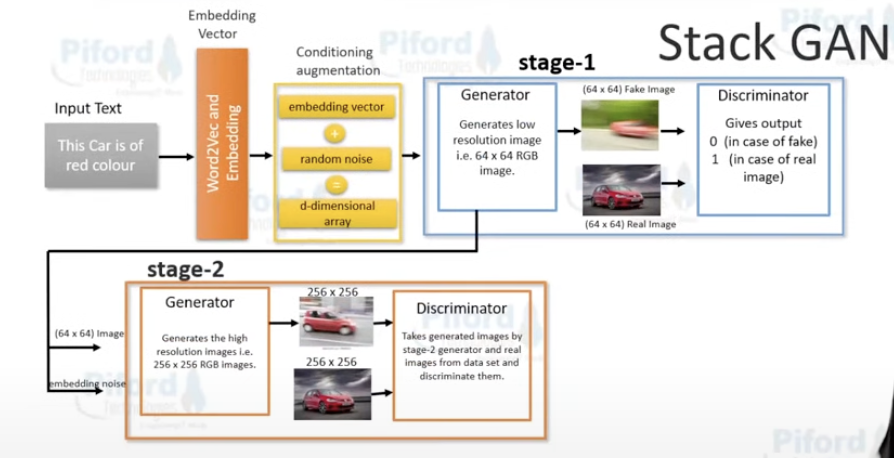

In [ ]:
#Importing Dependencies
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import pickle
import random
import time

import numpy as np
import pandas as pd
import tensorflow as tf

assert tf.__version__.startswith('2')

import PIL
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LeakyReLU, BatchNormalization, ReLU, Activation
from tensorflow.keras.layers import UpSampling2D, Conv2D, Concatenate, Dense, concatenate
from tensorflow.keras.layers import Flatten, Lambda, Reshape, ZeroPadding2D, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Conditioning Augmentation

In [ ]:
"""The mean_logsigma passed as argument is converted into the text conditioning variable.

	Args:
		x: The output of the text embedding passed through a FC layer with LeakyReLU non-linearity.

	Returns:
	 	c: The text conditioning variable after computation.
	"""



def conditioning_augmentation(x):

  mean = x[:,:128]
  log_sigma = x[:,128:]

  stddev = tf.math.exp(log_sigma)
  epsilon = K.random_normal(shape=K.constant((mean.shape[1], ), dtype='int32'))
  c = mean + stddev * epsilon
  return c


def build_ca_network():
	"""Builds the conditioning augmentation network.
	"""
	input_layer1 = Input(shape=(1024,)) #size of the vocabulary in the text data
	mls = Dense(256)(input_layer1)
	mls = LeakyReLU(alpha=0.2)(mls)
	ca = Lambda(conditioning_augmentation)(mls)
	return Model(inputs=[input_layer1], outputs=[ca])

In [ ]:
#STAGE - 1 Generator
def UpSamplingBlock(x,num_kernels):
  x = UpSampling2D(size=(2,2))(x)
  x = Conv2D(num_kernels,kernel_size = (3,3),padding='same',strides=1,use_bias = False,kernel_initializer='he_uniform')(x)
  x = BatchNormalization(gamma_initializer='ones',beta_initializer='zeros')(x)
  x = ReLU()(x)
  return x

In [ ]:
#Stage-1 Generator

"""An Upsample block with Upsampling2D, Conv2D, BatchNormalization and a ReLU activation.

	Args:
		x: The preceding layer as input.
		num_kernels: Number of kernels for the Conv2D layer.

	Returns:
		x: The final activation layer after the Upsampling block.
	"""



def build_stage1_generator():

	input_layer1 = Input(shape=(1024,))
	ca = Dense(256)(input_layer1)
	ca = LeakyReLU(alpha=0.2)(ca)

	# Obtain the conditioned text
	c = Lambda(conditioning_augmentation)(ca)

	input_layer2 = Input(shape=(100,))
	concat = Concatenate(axis=1)([c, input_layer2])

	x = Dense(16384, use_bias=False)(concat)
	x = ReLU()(x)
	x = Reshape((4, 4, 1024), input_shape=(16384,))(x)

	x = UpSamplingBlock(x, 512)
	x = UpSamplingBlock(x, 256)
	x = UpSamplingBlock(x, 128)
	x = UpSamplingBlock(x, 64)   # upsampled our image to 64*64*3

	x = Conv2D(3, kernel_size=3, padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = Activation('tanh')(x)

	stage1_gen = Model(inputs=[input_layer1, input_layer2], outputs=[x, ca])
	return stage1_gen


In [ ]:
generator = build_stage1_generator()
generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 1024)]               0         []                            
                                                                                                  
 dense_2 (Dense)             (None, 256)                  262400    ['input_6[0][0]']             
                                                                                                  
 leaky_re_lu_3 (LeakyReLU)   (None, 256)                  0         ['dense_2[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 128)                  0         ['leaky_re_lu_3[0][0]']       
                                                                                            

In [ ]:
# Stage 1 Discriminator Network

"""A ConvBlock with a Conv2D, BatchNormalization and LeakyReLU activation.

	Args:
		x: The preceding layer as input.
		num_kernels: Number of kernels for the Conv2D layer.

	Returns:
		x: The final activation layer after the ConvBlock block.
	"""

def ConvBlock(x, num_kernels, kernel_size=(4,4), strides=2, activation=True):
  x = Conv2D(num_kernels, kernel_size=kernel_size, padding='same', strides=strides, use_bias=False,
				kernel_initializer='he_uniform')(x)
  x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)

  if activation:
  	x = LeakyReLU(alpha=0.2)(x)
  return x


def build_embedding_compressor():
  input_layer1 = Input(shape=(1024,))
  x = Dense(128)(input_layer1)
  x = ReLU()(x)

  model = Model(inputs=[input_layer1],outputs=[x])
  return model

In [ ]:

# building stage 1 DISCRIMINATOR
def build_stage1_discriminator():
	input_layer1 = Input(shape=(64, 64, 3))

	x = Conv2D(64, kernel_size=(4,4), strides=2, padding='same', use_bias=False,
				kernel_initializer='he_uniform')(input_layer1)
	x = LeakyReLU(alpha=0.2)(x)

	x = ConvBlock(x, 128)
	x = ConvBlock(x, 256)
	x = ConvBlock(x, 512)

	# Obtain the compressed and spatially replicated text embedding
	input_layer2 = Input(shape=(4, 4, 128)) #2nd input to discriminator, text embedding
	concat = concatenate([x, input_layer2])

	x1 = Conv2D(512, kernel_size=(1,1), padding='same', strides=1, use_bias=False,
				kernel_initializer='he_uniform')(concat)
	x1 = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x1 = LeakyReLU(alpha=0.2)(x)

	# Flatten and add a FC layer to predict.
	x1 = Flatten()(x1)
	x1 = Dense(1)(x1)
	x1 = Activation('sigmoid')(x1)

	stage1_dis = Model(inputs=[input_layer1, input_layer2], outputs=[x1])
	return stage1_dis


#Builds the Stage 1 Discriminator that uses the 64x64 resolution images from the generator
#	and the compressed and spatially replicated embedding.

#	Returns:
#		Stage 1 Discriminator Model for StackGAN.

In [ ]:
discriminator = build_stage1_discriminator()
discriminator.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 32, 32, 64)           3072      ['input_8[0][0]']             
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)           0         ['conv2d_23[0][0]']           
                                                                                                  
 conv2d_24 (Conv2D)          (None, 16, 16, 128)          131072    ['leaky_re_lu_4[0][0]']       
                                                                                            

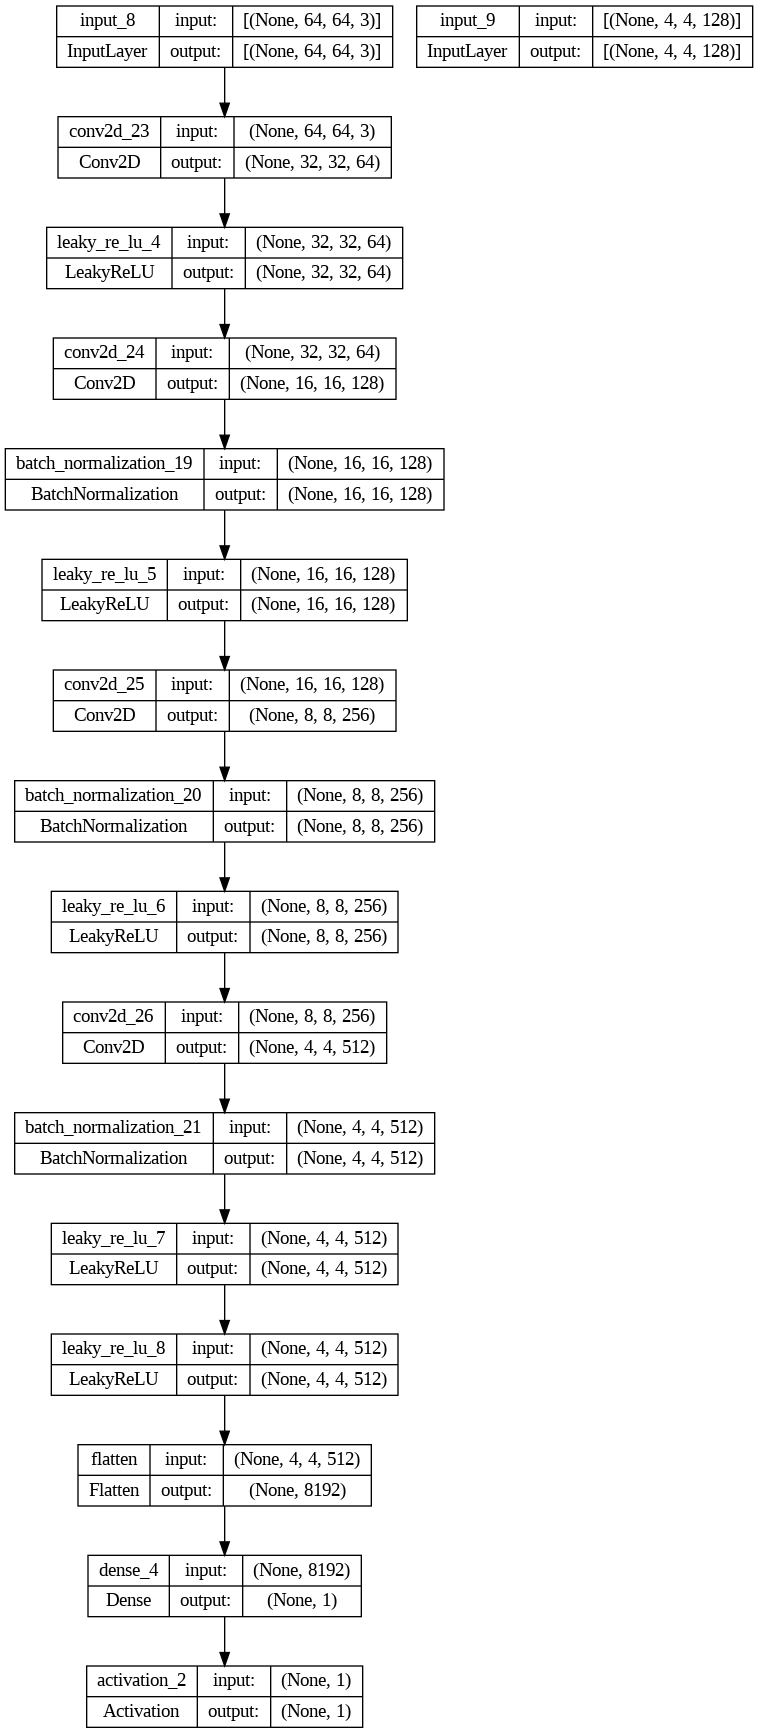

In [ ]:
plot_model(discriminator, show_shapes=True, show_layer_names=True)

In [ ]:
# Building GAN with Generator and Discriminator

def build_adversarial(generator_model, discriminator_model):
  input_layer1 = Input(shape=(1024,))
  input_layer2 = Input(shape=(100,))
  input_layer3 = Input(shape=(4, 4, 128))

  x, ca = generator_model([input_layer1, input_layer2]) #text,noise

  discriminator_model.trainable = False

  probabilities = discriminator_model([x, input_layer3])
  adversarial_model = Model(inputs=[input_layer1, input_layer2, input_layer3], outputs=[probabilities, ca])
  return adversarial_model

In [ ]:
ganstage1 = build_adversarial(generator, discriminator)
ganstage1.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 1024)]               0         []                            
                                                                                                  
 input_11 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 model_1 (Functional)        [(None, 64, 64, 3),          1027040   ['input_10[0][0]',            
                              (None, 256)]                0          'input_11[0][0]']            
                                                                                                  
 input_12 (InputLayer)       [(None, 4, 4, 128)]          0         []                      

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

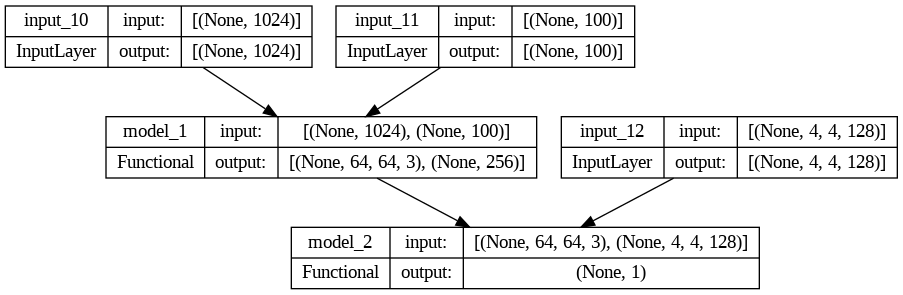

In [ ]:
plot_model(ganstage1, show_shapes=True, show_layer_names=True)

## Train Utilities

In [ ]:
def checkpoint_prefix():
	checkpoint_dir = './training_checkpoints'
	checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

	return checkpoint_prefix

def adversarial_loss(y_true, y_pred):
	mean = y_pred[:, :128]
	ls = y_pred[:, 128:]
	loss = -ls + 0.5 * (-1 + tf.math.exp(2.0 * ls) + tf.math.square(mean))
	loss = K.mean(loss)
	return loss

def normalize(input_image, real_image):
	input_image = (input_image / 127.5) - 1
	real_image = (real_image / 127.5) - 1

	return input_image, real_image

def load_class_ids_filenames(class_id_path, filename_path):
	with open(class_id_path, 'rb') as file:
		class_id = pickle.load(file, encoding='latin1')

	with open(filename_path, 'rb') as file:
		filename = pickle.load(file, encoding='latin1')

	return class_id, filename

def load_text_embeddings(text_embeddings):
	with open(text_embeddings, 'rb') as file:
		embeds = pickle.load(file, encoding='latin1')
		embeds = np.array(embeds)

	return embeds

def load_bbox(data_path):
	bbox_path = data_path + '/bounding_boxes.txt'
	image_path = data_path + '/images.txt'
	bbox_df = pd.read_csv(bbox_path, delim_whitespace=True, header=None).astype(int)
	filename_df = pd.read_csv(image_path, delim_whitespace=True, header=None)

	filenames = filename_df[1].tolist()
	bbox_dict = {i[:-4]:[] for i in filenames[:2]}

	for i in range(0, len(filenames)):
		bbox = bbox_df.iloc[i][1:].tolist()
		dict_key = filenames[i][:-4]
		bbox_dict[dict_key] = bbox

	return bbox_dict

def load_images(image_path, bounding_box, size):
	"""Crops the image to the bounding box and then resizes it.
	"""
	image = Image.open(image_path).convert('RGB')
	w, h = image.size
	if bounding_box is not None:
		r = int(np.maximum(bounding_box[2], bounding_box[3]) * 0.75)
		c_x = int((bounding_box[0] + bounding_box[2]) / 2)
		c_y = int((bounding_box[1] + bounding_box[3]) / 2)
		y1 = np.maximum(0, c_y - r)
		y2 = np.minimum(h, c_y + r)
		x1 = np.maximum(0, c_x - r)
		x2 = np.minimum(w, c_x + r)
		image = image.crop([x1, y1, x2, y2])

	image = image.resize(size, PIL.Image.BILINEAR)
	return image

def load_data(filename_path, class_id_path, dataset_path, embeddings_path, size):
	"""Loads the Dataset.
	"""
	data_dir = "D:/1-pipelined_topics/GAN_texttoimage/birds_implementation/birds"
	train_dir = data_dir + "/train"
	test_dir = data_dir + "/test"
	embeddings_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
	embeddings_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"
	filename_path_train = train_dir + "/filenames.pickle"
	filename_path_test = test_dir + "/filenames.pickle"
	class_id_path_train = train_dir + "/class_info.pickle"
	class_id_path_test = test_dir + "/class_info.pickle"
	dataset_path = "D:/1-pipelined_topics/GAN_texttoimage/birds_implementation/CUB_200_2011"
	class_id, filenames = load_class_ids_filenames(class_id_path, filename_path)
	embeddings = load_text_embeddings(embeddings_path)
	bbox_dict = load_bbox(dataset_path)

	x, y, embeds = [], [], []

	for i, filename in enumerate(filenames):
		bbox = bbox_dict[filename]

		try:
			image_path = f'{dataset_path}/images/{filename}.jpg'
			image = load_images(image_path, bbox, size)
			e = embeddings[i, :, :]
			embed_index = np.random.randint(0, e.shape[0] - 1)
			embed = e[embed_index, :]

			x.append(np.array(image))
			y.append(class_id[i])
			embeds.append(embed)

		except Exception as e:
			print(f'{e}')

	x = np.array(x)
	y = np.array(y)
	embeds = np.array(embeds)

	return x, y, embeds

def save_image(file, save_path):
	"""Saves the image at the specified file path.
	"""
	image = plt.figure()
	ax = image.add_subplot(1,1,1)
	ax.imshow(file)
	ax.axis("off")
	plt.savefig(save_path)


The constructor also creates and compiles various components:

The Stage 1 generator, which is compiled with a mean squared error (MSE) loss function.
The Stage 1 discriminator, which is compiled with binary cross-entropy loss.
The Conditioning Augmentation (CA) network, not shown in the provided code.
The Embedding Compressor, not shown in the provided code.
The Stage 1 adversarial model, which combines the Stage 1 generator and discriminator and is compiled with custom loss functions and weights.

In [ ]:
class StackGanStage1(object):
  """StackGAN Stage 1 class."""

  data_dir = "D:/1-pipelined_topics/GAN_texttoimage/birds_implementation/birds"
  train_dir = data_dir + "/train"
  test_dir = data_dir + "/test"
  embeddings_path_train = train_dir + "/char-CNN-RNN-embeddings.pickle"
  embeddings_path_test = test_dir + "/char-CNN-RNN-embeddings.pickle"
  filename_path_train = train_dir + "/filenames.pickle"
  filename_path_test = test_dir + "/filenames.pickle"
  class_id_path_train = train_dir + "/class_info.pickle"
  class_id_path_test = test_dir + "/class_info.pickle"
  dataset_path = "D:/1-pipelined_topics/GAN_texttoimage/birds_implementation/CUB_200_2011"

  def __init__(self, epochs=500, z_dim=100, batch_size=64, enable_function=True, stage1_generator_lr=0.0002, stage1_discriminator_lr=0.0002):
    self.epochs = epochs
    self.z_dim = z_dim
    self.enable_function = enable_function
    self.stage1_generator_lr = stage1_generator_lr
    self.stage1_discriminator_lr = stage1_discriminator_lr
    self.image_size = 64
    self.conditioning_dim = 128
    self.batch_size = batch_size

    self.stage1_generator_optimizer = Adam(lr=stage1_generator_lr, beta_1=0.5, beta_2=0.999)
    self.stage1_discriminator_optimizer = Adam(lr=stage1_discriminator_lr, beta_1=0.5, beta_2=0.999)

    self.stage1_generator = build_stage1_generator()
    self.stage1_generator.compile(loss='mse', optimizer=self.stage1_generator_optimizer)

    self.stage1_discriminator = build_stage1_discriminator()
    self.stage1_discriminator.compile(loss='binary_crossentropy', optimizer=self.stage1_discriminator_optimizer)

    self.ca_network = build_ca_network()
    self.ca_network.compile(loss='binary_crossentropy', optimizer='Adam')

    self.embedding_compressor = build_embedding_compressor()
    self.embedding_compressor.compile(loss='binary_crossentropy', optimizer='Adam')

    self.stage1_adversarial = build_adversarial(self.stage1_generator, self.stage1_discriminator)
    self.stage1_adversarial.compile(loss=['binary_crossentropy', adversarial_loss], loss_weights=[1, 2.0], optimizer=self.stage1_generator_optimizer)

    self.checkpoint1 = tf.train.Checkpoint(
        generator_optimizer=self.stage1_generator_optimizer,
        discriminator_optimizer=self.stage1_discriminator_optimizer,
        generator=self.stage1_generator,
        discriminator=self.stage1_discriminator)

  def visualize_stage1(self):
    """Running Tensorboard visualizations.
    """
    tb = TensorBoard(log_dir="logs/".format(time.time()))
    tb.set_model(self.stage1_generator)
    tb.set_model(self.stage1_discriminator)
    tb.set_model(self.ca_network)
    tb.set_model(self.embedding_compressor)


In [ ]:
def train_stage1(self):

	  x_train, y_train, train_embeds = load_data(filename_path=filename_path_train, class_id_path=class_id_path_train,
      dataset_path=dataset_path, embeddings_path=embeddings_path_train, size=(64, 64))

	  x_test, y_test, test_embeds = load_data(filename_path=filename_path_test, class_id_path=class_id_path_test,
      dataset_path=dataset_path, embeddings_path=embeddings_path_test, size=(64, 64))

	  real = np.ones((self.batch_size, 1), dtype='float') * 0.9
	  fake = np.zeros((self.batch_size, 1), dtype='float') * 0.1

	  for epoch in range(self.epochs):
		  print(f'Epoch: {epoch}')

		  gen_loss = []
		  dis_loss = []

		  num_batches = int(x_train.shape[0] / self.batch_size)

		  for i in range(num_batches):

		    latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
		    embedding_text = train_embeds[i * self.batch_size:(i + 1) * self.batch_size]


        compressed_embedding = self.embedding_compressor.predict_on_batch(embedding_text)
		    compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, 128))
		    compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))

		    image_batch = x_train[i * self.batch_size:(i+1) * self.batch_size]
		    image_batch = (image_batch - 127.5) / 127.5

		    gen_images, _ = self.stage1_generator.predict([embedding_text, latent_space])

		    discriminator_loss = self.stage1_discriminator.train_on_batch([image_batch, compressed_embedding],
					np.reshape(real, (self.batch_size, 1)))

		    discriminator_loss_gen = self.stage1_discriminator.train_on_batch([gen_images, compressed_embedding],
					np.reshape(fake, (self.batch_size, 1)))

		    discriminator_loss_wrong = self.stage1_discriminator.train_on_batch([gen_images[: self.batch_size-1], compressed_embedding[1:]],
					np.reshape(fake[1:], (self.batch_size-1, 1)))

		    # Discriminator loss
		    d_loss = 0.5 * np.add(discriminator_loss, 0.5 * np.add(discriminator_loss_gen, discriminator_loss_wrong))
		    dis_loss.append(d_loss)

		    print(f'Discriminator Loss: {d_loss}')

		    # Generator loss
		    g_loss = self.stage1_adversarial.train_on_batch([embedding_text, latent_space, compressed_embedding],
					[K.ones((self.batch_size, 1)) * 0.9, K.ones((self.batch_size, 256)) * 0.9])

		    print(f'Generator Loss: {g_loss}')
		    gen_loss.append(g_loss)

		    if epoch % 5 == 0:
				    latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
				    embedding_batch = test_embeds[0 : self.batch_size]
				    gen_images, _ = self.stage1_generator.predict_on_batch([embedding_batch, latent_space])

				    for i, image in enumerate(gen_images[:10]):
				        save_image(image, f'test/gen_1_{epoch}_{i}')

		    if epoch % 25 == 0:
		      self.stage1_generator.save_weights('weights/stage1_gen.h5')
		      self.stage1_discriminator.save_weights("weights/stage1_disc.h5")
		      self.ca_network.save_weights('weights/stage1_ca.h5')
		      self.embedding_compressor.save_weights('weights/stage1_embco.h5')
		      self.stage1_adversarial.save_weights('weights/stage1_adv.h5')

	  self.stage1_generator.save_weights('weights/stage1_gen.h5')
	  self.stage1_discriminator.save_weights("weights/stage1_disc.h5")


In [ ]:
stage1 = StackGanStage1()
stage1.train_stage1()


## STAGE 2 GENERATOR

In [ ]:
	"""Joins the conditioned text with the encoded image along the dimensions.

	Args:
		inputs: consisting of conditioned text and encoded images as [c,x].

	Returns:
		Joint block along the dimensions.
	"""
def concat_along_dims(inputs):
  c = inputs[0]
  x = inputs[1]

  c = K.expand_dims(c, axis=1)
  c = K.expand_dims(c, axis=1)
  c = K.tile(c, [1, 16, 16, 1])
  return K.concatenate([c, x], axis = 3)


In [ ]:
	"""Residual block with plain identity connections.

	Args:
		inputs: input layer or an encoded layer

	Returns:
		Layer with computed identity mapping.
	"""
def residual_block(input):

  x = Conv2D(512, kernel_size=(3,3), padding='same', use_bias=False,
				kernel_initializer='he_uniform')(input)
  x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
  x = ReLU()(x)

  x = Conv2D(512, kernel_size=(3,3), padding='same', use_bias=False,
				kernel_initializer='he_uniform')(x)
  x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)

  x = add([x, input])
  x = ReLU()(x)

  return x



In [ ]:
def build_stage2_generator():
	"""Build the Stage 2 Generator Network using the conditioning text and images from stage 1.

	Returns:
		Stage 2 Generator Model for StackGAN.
	"""
	input_layer1 = Input(shape=(1024,))
	input_images = Input(shape=(64, 64, 3))

	# Conditioning Augmentation
	ca = Dense(256)(input_layer1)
	mls = LeakyReLU(alpha=0.2)(ca)
	c = Lambda(conditioning_augmentation)(mls)

	# Downsampling block
	x = ZeroPadding2D(padding=(1,1))(input_images)
	x = Conv2D(128, kernel_size=(3,3), strides=1, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = ReLU()(x)

	x = ZeroPadding2D(padding=(1,1))(x)
	x = Conv2D(256, kernel_size=(4,4), strides=2, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)

	x = ZeroPadding2D(padding=(1,1))(x)
	x = Conv2D(512, kernel_size=(4,4), strides=2, use_bias=False,
				kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)

	# Concatenate text conditioning block with the encoded image
	concat = concat_along_dims([c, x])

  # Residual Blocks
	x = ZeroPadding2D(padding=(1,1))(concat)
	x = Conv2D(512, kernel_size=(3,3), use_bias=False, kernel_initializer='he_uniform')(x)
	x = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x)
	x = ReLU()(x)

	x = residual_block(x)
	x = residual_block(x)
	x = residual_block(x)
	x = residual_block(x)

	# Upsampling Blocks
	x = UpSamplingBlock(x, 512)
	x = UpSamplingBlock(x, 256)
	x = UpSamplingBlock(x, 128)
	x = UpSamplingBlock(x, 64)

	x = Conv2D(3, kernel_size=(3,3), padding='same', use_bias=False, kernel_initializer='he_uniform')(x)
	x = Activation('tanh')(x)

	stage2_gen = Model(inputs=[input_layer1, input_images], outputs=[x, mls])
	return stage2_gen

In [ ]:
generator_stage2 = build_stage2_generator()
generator_stage2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 66, 66, 3)            0         ['input_4[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 128)          3456      ['zero_padding2d[0][0]']      
                                                                                                  
 re_lu (ReLU)                (None, 64, 64, 128)          0         ['conv2d[0][0]']          

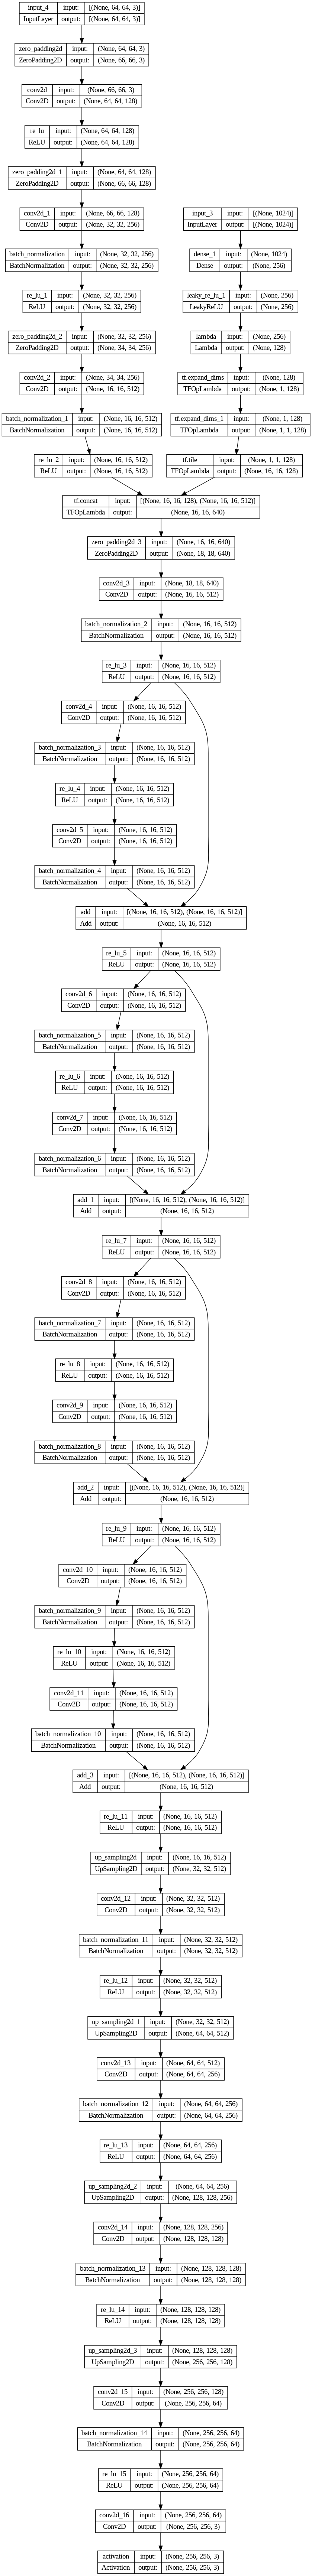

In [ ]:

from tensorflow.keras.utils import plot_model

plot_model(generator_stage2, show_shapes=True, show_layer_names=True)


In [ ]:
def build_stage2_discriminator():
	input_layer1 = Input(shape=(256, 256, 3))

	x = Conv2D(64, kernel_size=(4,4), padding='same', strides=2, use_bias=False,
				kernel_initializer='he_uniform')(input_layer1)
	x = LeakyReLU(alpha=0.2)(x)

	x = ConvBlock(x, 128)
	x = ConvBlock(x, 256)
	x = ConvBlock(x, 512)
	x = ConvBlock(x, 1024)
	x = ConvBlock(x, 2048)
	x = ConvBlock(x, 1024, (1,1), 1)
	x = ConvBlock(x, 512, (1,1), 1, False)

	x1 = ConvBlock(x, 128, (1,1), 1)
	x1 = ConvBlock(x1, 128, (3,3), 1)
	x1 = ConvBlock(x1, 512, (3,3), 1, False)

	x2 = add([x, x1])
	x2 = LeakyReLU(alpha=0.2)(x2)

	# Concatenate compressed and spatially replicated embedding
	input_layer2 = Input(shape=(4, 4, 128))
	concat = concatenate([x2, input_layer2])

	x3 = Conv2D(512, kernel_size=(1,1), strides=1, padding='same', kernel_initializer='he_uniform')(concat)
	x3 = BatchNormalization(gamma_initializer='ones', beta_initializer='zeros')(x3)
	x3 = LeakyReLU(alpha=0.2)(x3)

	# Flatten and add a FC layer
	x3 = Flatten()(x3)
	x3 = Dense(1)(x3)
	x3 = Activation('sigmoid')(x3)

	stage2_dis = Model(inputs=[input_layer1, input_layer2], outputs=[x3])
	return stage2_dis

  	#"""Builds the Stage 2 Discriminator that uses the 256x256 resolution images from the generator
	#and the compressed and spatially replicated embeddings.

#	Returns:
#		Stage 2 Discriminator Model for StackGAN.


In [ ]:
discriminator_stage2 = build_stage2_discriminator()
discriminator_stage2.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 128, 128, 64)         3072      ['input_13[0][0]']            
                                                                                                  
 leaky_re_lu_9 (LeakyReLU)   (None, 128, 128, 64)         0         ['conv2d_28[0][0]']           
                                                                                                  
 conv2d_29 (Conv2D)          (None, 64, 64, 128)          131072    ['leaky_re_lu_9[0][0]']       
                                                                                            

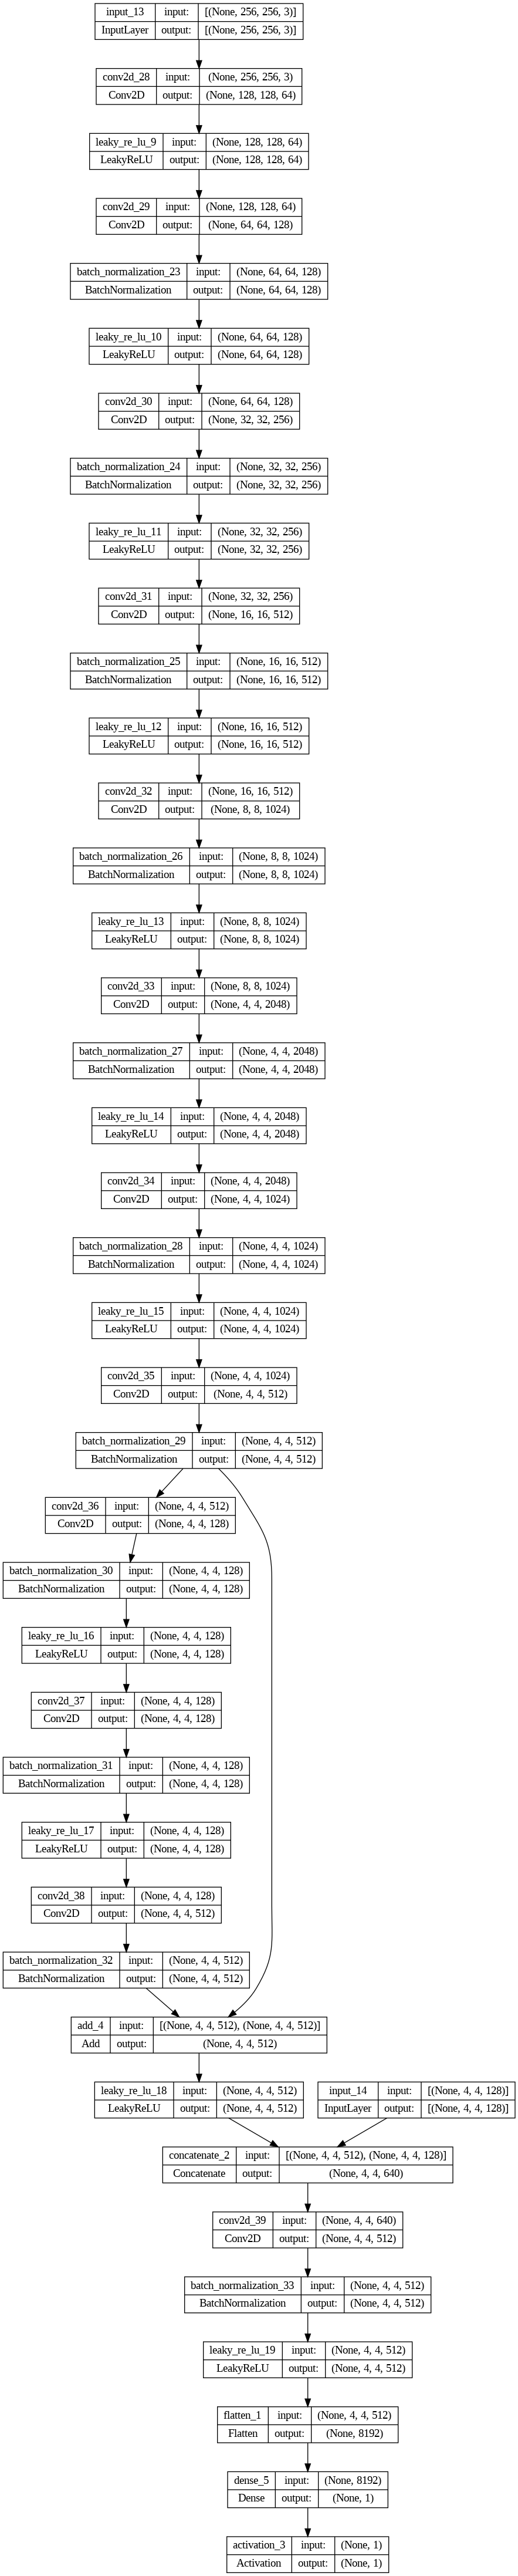

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(discriminator_stage2, show_shapes=True, show_layer_names=True)


In [ ]:
def stage2_adversarial_network(stage2_disc, stage2_gen, stage1_gen):

	conditioned_embedding = Input(shape=(1024, ))
	latent_space = Input(shape=(100, ))
	compressed_replicated = Input(shape=(4, 4, 128))

	#the discriminator is trained separately and stage1_gen already trained, and this is the reason why we freeze its layers by setting the property trainable=false
	input_images, ca = stage1_gen([conditioned_embedding, latent_space])
	stage2_disc.trainable = False
	stage1_gen.trainable = False

	images, ca2 = stage2_gen([conditioned_embedding, input_images])
	probability = stage2_disc([images, compressed_replicated])

	return Model(inputs=[conditioned_embedding, latent_space, compressed_replicated],
		outputs=[probability, ca2])

 	"""Stage 2 Adversarial Network.

	Args:
		stage2_disc: Stage 2 Discriminator Model.
		stage2_gen: Stage 2 Generator Model.
		stage1_gen: Stage 1 Generator Model.

	Returns:
		Stage 2 Adversarial network.
	"""

In [ ]:
adversarial_stage2 = stage2_adversarial_network(discriminator_stage2, generator_stage2, generator)
adversarial_stage2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 1024)]               0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 model_1 (Functional)        [(None, 64, 64, 3),          1027040   ['input_15[0][0]',            
                              (None, 256)]                0          'input_16[0][0]']            
                                                                                                  
 model (Functional)          [(None, 256, 256, 3),        2864544   ['input_15[0][0]',      

In [ ]:

class StackGanStage2(object):
	def __init__(self, epochs=500, z_dim=100, batch_size=64, enable_function=True, stage2_generator_lr=0.0002, stage2_discriminator_lr=0.0002):
		self.epochs = epochs
		self.z_dim = z_dim
		self.enable_function = enable_function
		self.stage1_generator_lr = stage2_generator_lr
		self.stage1_discriminator_lr = stage2_discriminator_lr
		self.low_image_size = 64
		self.high_image_size = 256
		self.conditioning_dim = 128
		self.batch_size = batch_size
		self.stage2_generator_optimizer = Adam(lr=stage2_generator_lr, beta_1=0.5, beta_2=0.999)
		self.stage2_discriminator_optimizer = Adam(lr=stage2_discriminator_lr, beta_1=0.5, beta_2=0.999)
		self.stage1_generator = build_stage1_generator()
		self.stage1_generator.compile(loss='binary_crossentropy', optimizer=self.stage2_generator_optimizer)
		self.stage1_generator.load_weights('weights/stage1_gen.h5')
		self.stage2_generator = build_stage2_generator()
		self.stage2_generator.compile(loss='binary_crossentropy', optimizer=self.stage2_generator_optimizer)

		self.stage2_discriminator = build_stage2_discriminator()
		self.stage2_discriminator.compile(loss='binary_crossentropy', optimizer=self.stage2_discriminator_optimizer)

		self.ca_network = build_ca_network()
		self.ca_network.compile(loss='binary_crossentropy', optimizer='Adam')

		self.embedding_compressor = build_embedding_compressor()
		self.embedding_compressor.compile(loss='binary_crossentropy', optimizer='Adam')

		self.stage2_adversarial = stage2_adversarial_network(self.stage2_discriminator, self.stage2_generator, self.stage1_generator)
		self.stage2_adversarial.compile(loss=['binary_crossentropy', adversarial_loss], loss_weights=[1, 2.0], optimizer=self.stage2_generator_optimizer)

		self.checkpoint2 = tf.train.Checkpoint(
        	generator_optimizer=self.stage2_generator_optimizer,
        	discriminator_optimizer=self.stage2_discriminator_optimizer,
        	generator=self.stage2_generator,
        	discriminator=self.stage2_discriminator,
        	generator1=self.stage1_generator)
  def visualize_stage2(self):

		tb = TensorBoard(log_dir="logs/".format(time.time()))
		tb.set_model(self.stage2_generator)
		tb.set_model(self.stage2_discriminator)

	def train_stage2(self):

		x_high_train, y_high_train, high_train_embeds = load_data(filename_path=filename_path_train, class_id_path=class_id_path_train,
      dataset_path=dataset_path, embeddings_path=embeddings_path_train, size=(256, 256))

		x_high_test, y_high_test, high_test_embeds = load_data(filename_path=filename_path_test, class_id_path=class_id_path_test,
      dataset_path=dataset_path, embeddings_path=embeddings_path_test, size=(256, 256))

		x_low_train, y_low_train, low_train_embeds = load_data(filename_path=filename_path_train, class_id_path=class_id_path_train,
      dataset_path=dataset_path, embeddings_path=embeddings_path_train, size=(64, 64))

		x_low_test, y_low_test, low_test_embeds = load_data(filename_path=filename_path_test, class_id_path=class_id_path_test,
      dataset_path=dataset_path, embeddings_path=embeddings_path_test, size=(64, 64))

		real = np.ones((self.batch_size, 1), dtype='float') * 0.9
		fake = np.zeros((self.batch_size, 1), dtype='float') * 0.1

		for epoch in range(self.epochs):
			print(f'Epoch: {epoch}')

			gen_loss = []
			disc_loss = []

			num_batches = int(x_high_train.shape[0] / self.batch_size)

			for i in range(num_batches):

				latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
				embedding_text = high_train_embeds[i * self.batch_size:(i + 1) * self.batch_size]
				compressed_embedding = self.embedding_compressor.predict_on_batch(embedding_text)
				compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, self.conditioning_dim))
				compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))
        def visualize_stage2(self):
		"""Running Tensorboard visualizations.
		"""
		tb = TensorBoard(log_dir="logs/".format(time.time()))
		tb.set_model(self.stage2_generator)
		tb.set_model(self.stage2_discriminator)

	def train_stage2(self):
		"""Trains Stage 2 StackGAN.
		"""
		x_high_train, y_high_train, high_train_embeds = load_data(filename_path=filename_path_train, class_id_path=class_id_path_train,
      dataset_path=dataset_path, embeddings_path=embeddings_path_train, size=(256, 256))

		x_high_test, y_high_test, high_test_embeds = load_data(filename_path=filename_path_test, class_id_path=class_id_path_test,
      dataset_path=dataset_path, embeddings_path=embeddings_path_test, size=(256, 256))

		x_low_train, y_low_train, low_train_embeds = load_data(filename_path=filename_path_train, class_id_path=class_id_path_train,
      dataset_path=dataset_path, embeddings_path=embeddings_path_train, size=(64, 64))

		x_low_test, y_low_test, low_test_embeds = load_data(filename_path=filename_path_test, class_id_path=class_id_path_test,
      dataset_path=dataset_path, embeddings_path=embeddings_path_test, size=(64, 64))

		real = np.ones((self.batch_size, 1), dtype='float') * 0.9
		fake = np.zeros((self.batch_size, 1), dtype='float') * 0.1

		for epoch in range(self.epochs):
			print(f'Epoch: {epoch}')

			gen_loss = []
			disc_loss = []

			num_batches = int(x_high_train.shape[0] / self.batch_size)

			for i in range(num_batches):

				latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
				embedding_text = high_train_embeds[i * self.batch_size:(i + 1) * self.batch_size]
				compressed_embedding = self.embedding_compressor.predict_on_batch(embedding_text)
				compressed_embedding = np.reshape(compressed_embedding, (-1, 1, 1, self.conditioning_dim))
				compressed_embedding = np.tile(compressed_embedding, (1, 4, 4, 1))
        image_batch = x_high_train[i * self.batch_size:(i+1) * self.batch_size]
				image_batch = (image_batch - 127.5) / 127.5

				low_res_fakes, _ = self.stage1_generator.predict([embedding_text, latent_space], verbose=3)
				high_res_fakes, _ = self.stage2_generator.predict([embedding_text, low_res_fakes], verbose=3)

				discriminator_loss = self.stage2_discriminator.train_on_batch([image_batch, compressed_embedding],
					np.reshape(real, (self.batch_size, 1)))

				discriminator_loss_gen = self.stage2_discriminator.train_on_batch([high_res_fakes, compressed_embedding],
					np.reshape(fake, (self.batch_size, 1)))

				discriminator_loss_fake = self.stage2_discriminator.train_on_batch([image_batch[:(self.batch_size-1)], compressed_embedding[1:]],
					np.reshape(fake[1:], (self.batch_size - 1, 1)))

				d_loss = 0.5 * np.add(discriminator_loss, 0.5 * np.add(discriminator_loss_gen, discriminator_loss_fake))
				disc_loss.append(d_loss)

				print(f'Discriminator Loss: {d_loss}')

				g_loss = self.stage2_adversarial.train_on_batch([embedding_text, latent_space, compressed_embedding],
					[K.ones((self.batch_size, 1)) * 0.9, K.ones((self.batch_size, 256)) * 0.9])
				gen_loss.append(g_loss)

				print(f'Generator Loss: {g_loss}')

				if epoch % 5 == 0:
					latent_space = np.random.normal(0, 1, size=(self.batch_size, self.z_dim))
					embedding_batch = high_test_embeds[0 : self.batch_size]

					low_fake_images, _ = self.stage1_generator.predict([embedding_batch, latent_space], verbose=3)
					high_fake_images, _ = self.stage2_generator.predict([embedding_batch, low_fake_images], verbose=3)

					for i, image in enumerate(high_fake_images[:10]):
					    save_image(image, f'results_stage2/gen_{epoch}_{i}.png')

				if epoch % 10 == 0:
					self.stage2_generator.save_weights('weights/stage2_gen.h5')
					self.stage2_discriminator.save_weights("weights/stage2_disc.h5")
					self.ca_network.save_weights('weights/stage2_ca.h5')
					self.embedding_compressor.save_weights('weights/stage2_embco.h5')
					self.stage2_adversarial.save_weights('weights/stage2_adv.h5')

		self.stage2_generator.save_weights('weights/stage2_gen.h5')
		self.stage2_discriminator.save_weights("weights/stage2_disc.h5")

